# WiDS Datathon 2020 - Predictive Analytics Challenge 

#### Building a predictive model to predict the probability of patient’s survival using existing data from first 24 hours of intensive care

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set(font_scale = 1.2)
import matplotlib.pyplot as plt
%matplotlib inline
import math
import xgboost as xgb
import tensorflow as tf

from  sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
#from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
#from tensorflow.keras.callbacks import ModelCheckpoint
#from keras.callbacks import Callback, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import tree
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


#pip install plotnine
from pandas.api.types import CategoricalDtype
from plotnine import *

Using TensorFlow backend.


## Read Data

In [2]:
training = pd.read_csv("training_v2.csv")
unlabeled = pd.read_csv("unlabeled.csv")

In [3]:
training.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [4]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


In [5]:
unlabeled.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,2,127112,7,NaN,56.0,21.102439,0,Caucasian,M,180.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
1,5,130737,178,NaN,NaN,19.500595,1,Caucasian,F,145.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
2,7,101458,86,NaN,66.0,32.518596,1,African American,M,170.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
3,8,48067,163,NaN,64.0,20.798520,0,Caucasian,M,182.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Respiratory,Respiratory
4,10,25865,59,NaN,56.0,NaN,0,Caucasian,M,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic


In [6]:
unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39308 entries, 0 to 39307
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(171), int64(7), object(8)
memory usage: 55.8+ MB


## Combine the two datsets for data validation and cleaning

In [7]:
wids = pd.concat([training, unlabeled])

In [8]:
wids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131021 entries, 0 to 39307
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(171), int64(7), object(8)
memory usage: 186.9+ MB


In [9]:
type(wids)

pandas.core.frame.DataFrame

In [10]:
wids.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0.0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0.0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0.0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0.0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0.0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


## Data Analysis 

A variety of scoring systems are used to quantify the severity of illness of patients admitted to the ICU and to predict their chances of survival to ICU and hospital discharge.Such prognostic scoring systems include the Simplified Acute Physiology Score (SAPS), the Mortality Probability Model (MPM) and the Acute Physiology and Chronic Health Evaluation (APACHE) scoring system.[4]  

APACHE has been used in our dataset to quanitify the severetity of illness of patients and to predict their chances of survival. APACHE was introduced in the early 1980s and few major revisions have occurred since then. APACHE II and III used in our dataset are two of such revisions and have been used in a significant number of ICUs for the past 15 years.

## Drop unnecessary columns before analyzing data

APACHE II and III are calculated using several vital measurements. A snippet of APACHE II calculator looks like the image below where the necessary measurements are used to calculate the APACHE score:

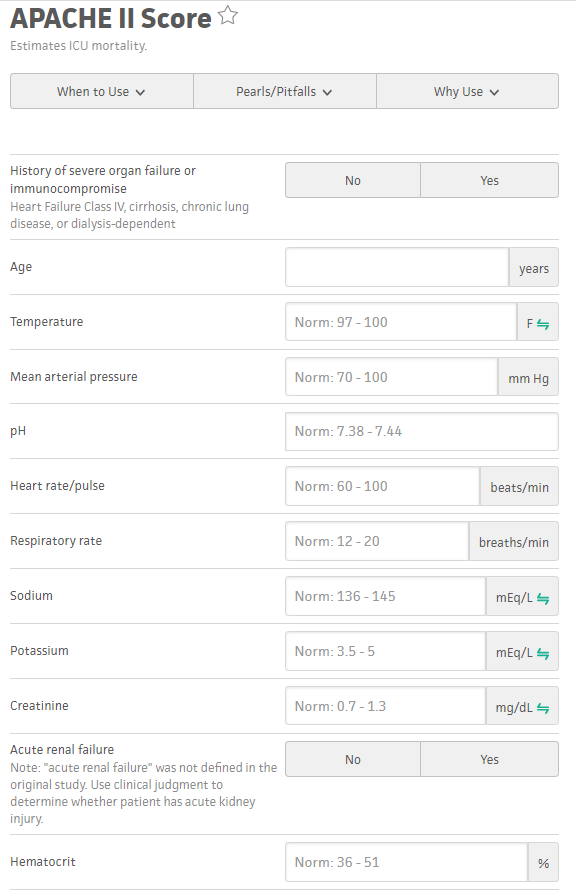

Similary, APACHE III score is also calculated using several vital measurements.

Because our dataset includes both the vital measurements and the APACHE II and III scores. We do not need the variables that represent vital measurements. We only need APACHE II and APACHE III scores to study the patient's survival. That's why we remove such variables from our dataset as seen below.

We also remove height and weight as those are used to calculate the variable "bmi".

We further remove all ids as it will not help us in prediction of patient's survival. We also remove few more variables that we think do not contribute to the research question such as hospital_admit_source, icu_admit_source', icu_stay_type, readmission_status, and elective_surgery. 

In [11]:
wids.drop(['encounter_id', 'albumin_apache', 'patient_id', 'hospital_id', 'height', 'weight', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'readmission_status', 'elective_surgery', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min'], axis = 1, inplace = True)

In [12]:
wids.drop(wids.loc[:,'arf_apache':'h1_pao2fio2ratio_min'], axis = 1, inplace = True)

Now we have the necessary variables that will be used for the study of patient's survival

In [13]:
wids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131021 entries, 0 to 39307
Data columns (total 22 columns):
hospital_death                   91713 non-null float64
age                              125139 non-null float64
bmi                              126506 non-null float64
ethnicity                        129455 non-null object
gender                           130981 non-null object
icu_type                         131021 non-null object
pre_icu_los_days                 131021 non-null float64
apache_2_diagnosis               128463 non-null float64
apache_3j_diagnosis              129283 non-null float64
apache_post_operative            131021 non-null int64
apache_4a_hospital_death_prob    117896 non-null float64
apache_4a_icu_death_prob         117896 non-null float64
aids                             130127 non-null float64
cirrhosis                        130127 non-null float64
diabetes_mellitus                130127 non-null float64
hepatic_failure                  130127 n

In [14]:
wids.shape

(131021, 22)

In [15]:
wids.columns

Index(['hospital_death', 'age', 'bmi', 'ethnicity', 'gender', 'icu_type',
       'pre_icu_los_days', 'apache_2_diagnosis', 'apache_3j_diagnosis',
       'apache_post_operative', 'apache_4a_hospital_death_prob',
       'apache_4a_icu_death_prob', 'aids', 'cirrhosis', 'diabetes_mellitus',
       'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object')

## Graphical Exploratory Analysis

Before we go deeper into the dataset, it is good to perform some graphical exploratory analysis as we can quickly see and find issues with the data 

### Univariate Analysis

### Age

C:\Users\kamsi\Anaconda3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_bin : Removed 5882 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


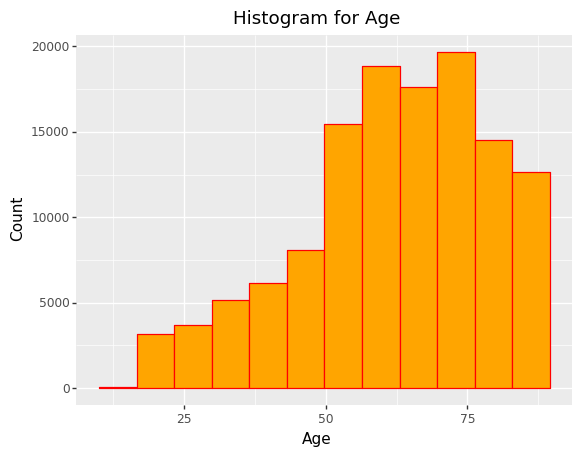

<ggplot: (-9223371876431222444)>

In [16]:
(ggplot(wids, aes(x='age'))   
 + geom_histogram(bins=12,
                 color ="red", 
                 fill ="orange")
 + labs(title="Histogram for Age", x="Age", y="Count")
)

It is clearly seen that majority of patients are over 50 years old

C:\Users\kamsi\Anaconda3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_density : Removed 5882 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


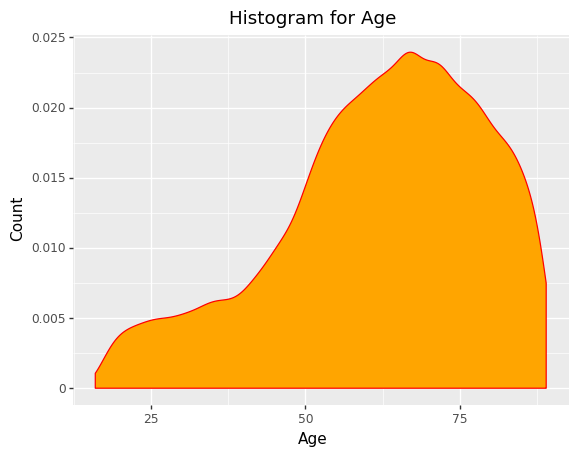

<ggplot: (-9223371876431575768)>

In [17]:
(ggplot(wids, aes(x='age'))   
 + geom_density( color ="red", 
                 fill ="orange")
 + labs(title="Histogram for Age", x="Age", y="Count")
)

## APACHE II scores

C:\Users\kamsi\Anaconda3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_bin : Removed 2558 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


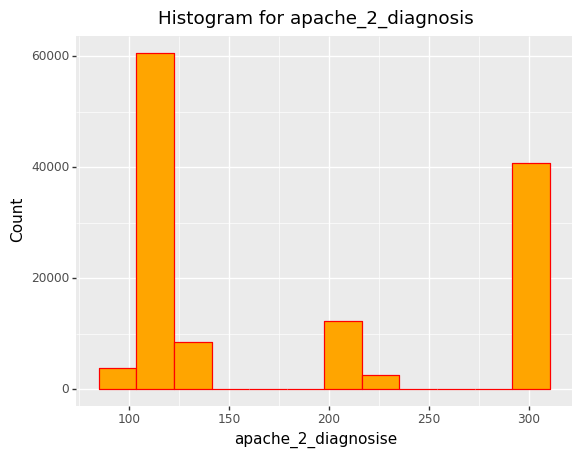

<ggplot: (-9223371876431663696)>

In [18]:
(ggplot(wids, aes(x='apache_2_diagnosis'))   
 + geom_histogram(bins=12,
                 color ="red", 
                 fill ="orange")
 + labs(title="Histogram for apache_2_diagnosis", x="apache_2_diagnosise", y="Count")
)

Majority of APACHE II scores are in the range of 100 to 125 and some in 300s few have other ranges 

## APACHE III scores

C:\Users\kamsi\Anaconda3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_bin : Removed 1738 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


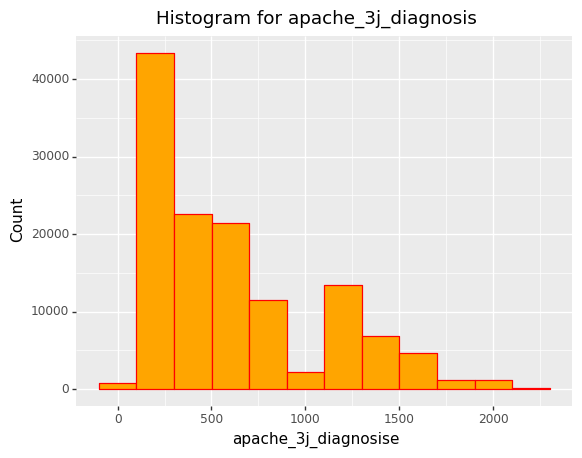

<ggplot: (-9223371876431430716)>

In [19]:
(ggplot(wids, aes(x='apache_3j_diagnosis'))   
 + geom_histogram(bins=12,
                 color ="red", 
                 fill ="orange")
 + labs(title="Histogram for apache_3j_diagnosis", x="apache_3j_diagnosise", y="Count")
)

Majority of APACHE III scores are in the range of 200 to 250 

### BMI

C:\Users\kamsi\Anaconda3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_bin : Removed 4515 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


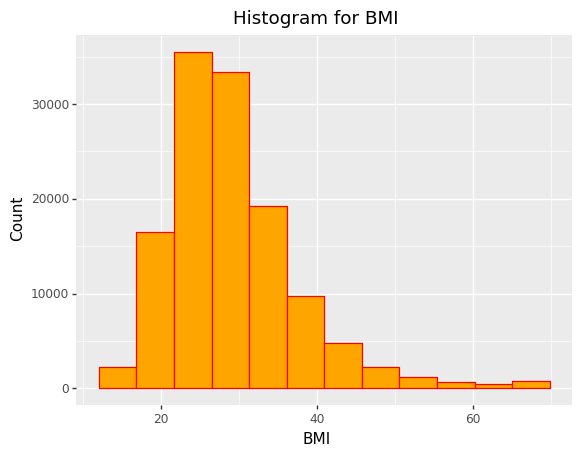

<ggplot: (-9223371876431496796)>

In [20]:
(ggplot(wids, aes(x='bmi'))   
 + geom_histogram(bins=12,
                 color ="red", 
                 fill ="orange")
 + labs(title="Histogram for BMI", x="BMI", y="Count")
)

BMI for majority of patients ranges from 25 to 35

## Describe Categorical Columns

In [21]:
wids.describe(include = 'O')

,ethnicity,gender,icu_type,apache_3j_bodysystem,apache_2_bodysystem
count,129455,130981,131021,128463,128463
unique,6,2,8,11,10
top,Caucasian,M,Med-Surg ICU,Cardiovascular,Cardiovascular
freq,100924,70981,71954,41392,53645


## Gender

In [22]:
wids['gender'].value_counts()

M    70981
F    60000
Name: gender, dtype: int64

In [23]:
wids['gender'].replace(0, "Unknown", inplace = True)
wids['gender'].replace("M", "Male", inplace = True)
wids['gender'].replace("F", "Female", inplace = True)

C:\Users\kamsi\Anaconda3\lib\site-packages\plotnine\stats\stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


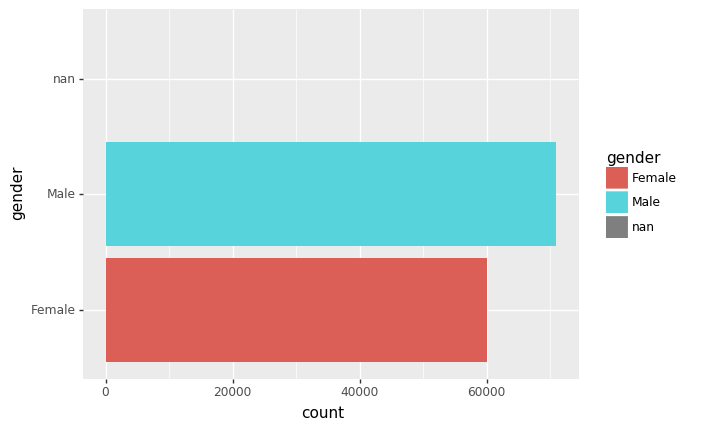

<ggplot: (-9223371876431462188)>

In [24]:
(ggplot(wids, aes(x = 'gender', fill = 'gender'))
 + geom_bar()
+ coord_flip())

### Ethnicity

In [25]:
wids['ethnicity'].value_counts()

Caucasian           100924
African American     14018
Other/Unknown         6295
Hispanic              5087
Asian                 2209
Native American        922
Name: ethnicity, dtype: int64

In [26]:
wids['ethnicity'].replace(0, "Other/Unknown", inplace = True)

C:\Users\kamsi\Anaconda3\lib\site-packages\plotnine\stats\stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


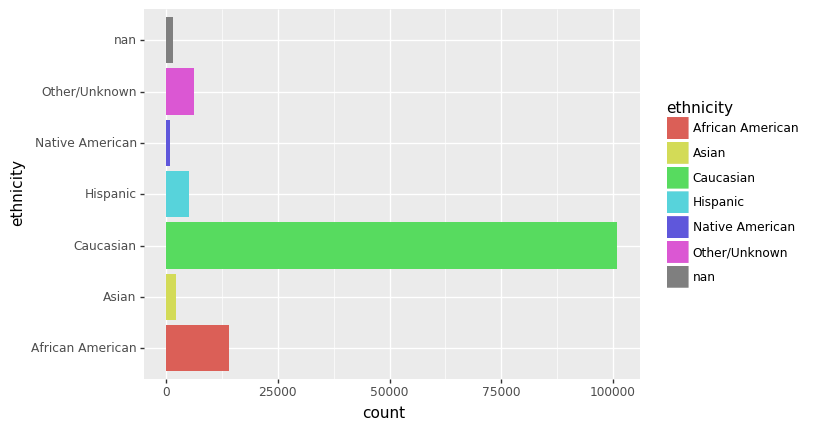

<ggplot: (-9223371876431323996)>

In [27]:
(ggplot(wids, aes(x = 'ethnicity', fill = 'ethnicity'))
 + geom_bar()
+ coord_flip())

### ICU_Type

In [28]:
wids['icu_type'].value_counts()

Med-Surg ICU    71954
CCU-CTICU       11279
MICU            11007
Neuro ICU       10616
Cardiac ICU      8337
SICU             8305
CSICU            5021
CTICU            4502
Name: icu_type, dtype: int64

In [29]:
wids['icu_type'].replace(0, "Unknown", inplace = True)

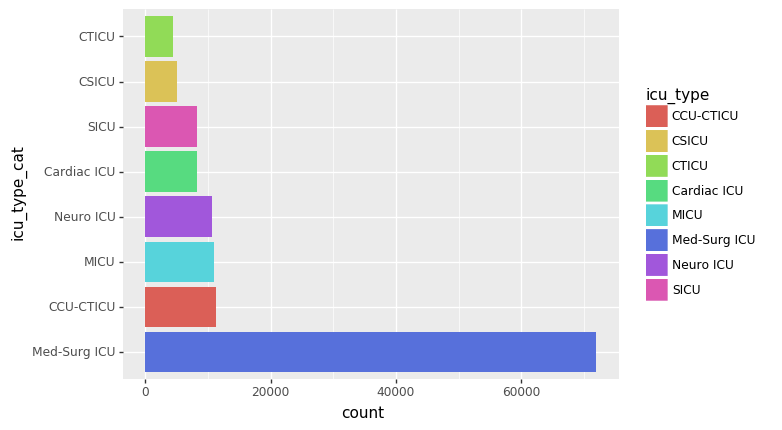

<ggplot: (-9223371876430997332)>

In [30]:

# Determine order and create a categorical type
# Note that value_counts() is already sorted
icu_type_list = wids['icu_type'].value_counts().index.tolist()
icu_type_cat = pd.Categorical(wids['icu_type'], categories=icu_type_list)

# assign to a new column in the DataFrame
wids = wids.assign(icu_type_cat = icu_type_cat)

(ggplot(wids, aes(x = 'icu_type_cat', fill = 'icu_type'))
 + geom_bar()
+ coord_flip())

### Apache III Bodysystems

In [31]:
wids['apache_3j_bodysystem'].value_counts()

Cardiovascular          41392
Neurological            17885
Respiratory             16893
Sepsis                  16402
Gastrointestinal        12975
Metabolic               10751
Trauma                   6237
Genitourinary            2992
Musculoskeletal/Skin     1669
Hematological             830
Gynecological             437
Name: apache_3j_bodysystem, dtype: int64

In [32]:
wids['apache_3j_bodysystem'].replace(0, "Undefined diagnoses", inplace = True)

C:\Users\kamsi\Anaconda3\lib\site-packages\plotnine\stats\stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


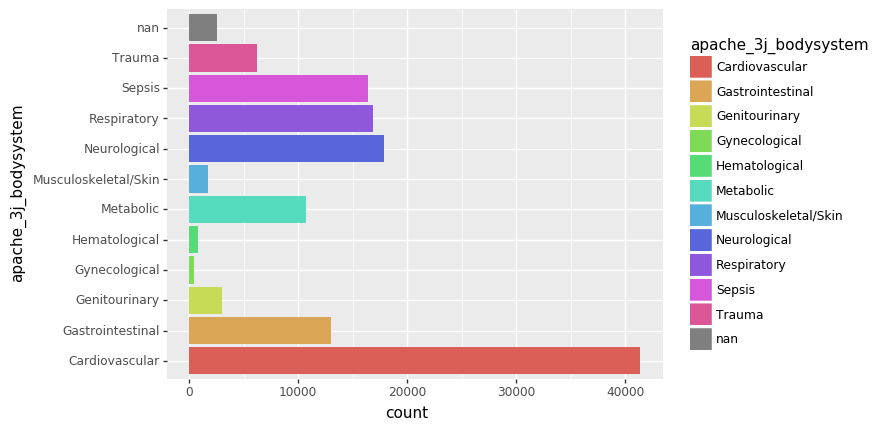

<ggplot: (-9223371876430997320)>

In [33]:
(ggplot(wids, aes(x = 'apache_3j_bodysystem', fill = 'apache_3j_bodysystem'))
 + geom_bar()
+ coord_flip())

### Apache II Bodysystems

In [34]:
wids['apache_2_bodysystem'].value_counts()

Cardiovascular         53645
Neurologic             17885
Respiratory            16893
Gastrointestinal       12975
Metabolic              10751
Trauma                  6237
Undefined diagnoses     5368
Renal/Genitourinary     3392
Haematologic             830
Undefined Diagnoses      487
Name: apache_2_bodysystem, dtype: int64

In [35]:
wids['apache_2_bodysystem'].replace("Undefined Diagnoses", "Undefined diagnoses", inplace = True)
wids['apache_2_bodysystem'].replace(0, "Undefined diagnoses", inplace = True)

C:\Users\kamsi\Anaconda3\lib\site-packages\plotnine\stats\stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


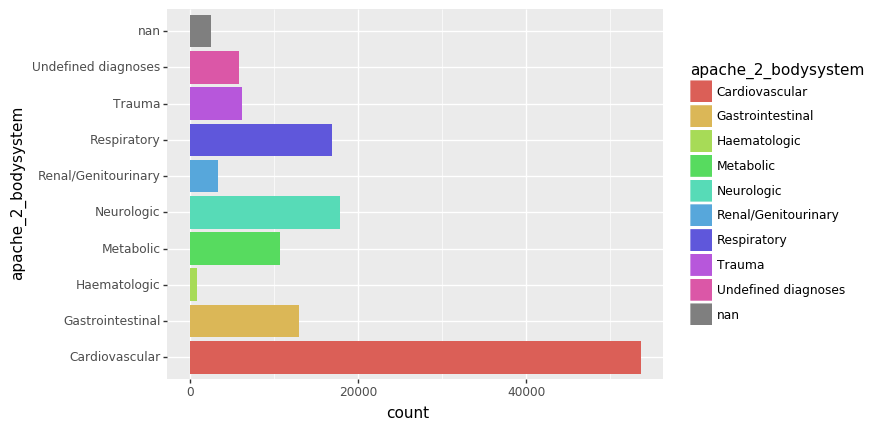

<ggplot: (-9223371876430997264)>

In [36]:
(ggplot(wids, aes(x = 'apache_2_bodysystem', fill = 'apache_2_bodysystem'))
 + geom_bar()
+ coord_flip())

## All Graphs

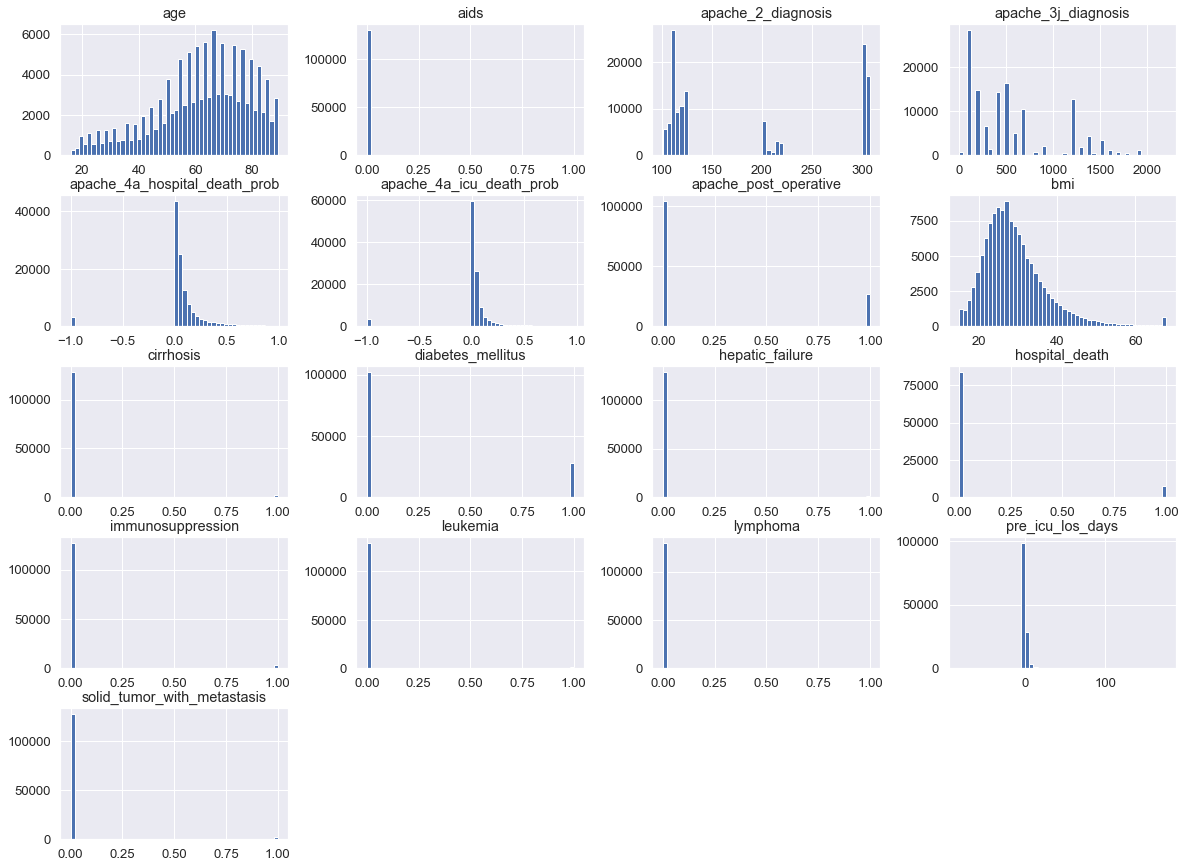

In [37]:
wids.hist(bins = 50, figsize = (20,15))
plt.show()

## Convert Categorical Columns to Numerical

### Get Dummy Variables

In [38]:
wids = pd.get_dummies(wids, columns = ['ethnicity', 'gender', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem'], drop_first = True)

In [39]:
wids.drop(['icu_type_cat'], axis = 1, inplace = True)

In [40]:
wids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131021 entries, 0 to 39307
Data columns (total 48 columns):
hospital_death                               91713 non-null float64
age                                          125139 non-null float64
bmi                                          126506 non-null float64
pre_icu_los_days                             131021 non-null float64
apache_2_diagnosis                           128463 non-null float64
apache_3j_diagnosis                          129283 non-null float64
apache_post_operative                        131021 non-null int64
apache_4a_hospital_death_prob                117896 non-null float64
apache_4a_icu_death_prob                     117896 non-null float64
aids                                         130127 non-null float64
cirrhosis                                    130127 non-null float64
diabetes_mellitus                            130127 non-null float64
hepatic_failure                              130127 non-null floa

## Check for Missing Values 

In [41]:
wids.isnull().sum()

hospital_death                               39308
age                                           5882
bmi                                           4515
pre_icu_los_days                                 0
apache_2_diagnosis                            2558
apache_3j_diagnosis                           1738
apache_post_operative                            0
apache_4a_hospital_death_prob                13125
apache_4a_icu_death_prob                     13125
aids                                           894
cirrhosis                                      894
diabetes_mellitus                              894
hepatic_failure                                894
immunosuppression                              894
leukemia                                       894
lymphoma                                       894
solid_tumor_with_metastasis                    894
ethnicity_Asian                                  0
ethnicity_Caucasian                              0
ethnicity_Hispanic             

## Adjust Missing Values

In [42]:
columns = ['aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']
wids[columns] = wids[columns].fillna(wids.mode().iloc[0])

In [43]:
cols = ['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']
wids[cols] = wids[cols].fillna(wids.median().iloc[0])

In [44]:
column = ['age', 'bmi', 'apache_2_diagnosis', 'apache_3j_diagnosis']
wids[column] = wids[column].fillna(wids.mean().iloc[0])

In [45]:
wids.isnull().sum()

hospital_death                               39308
age                                              0
bmi                                              0
pre_icu_los_days                                 0
apache_2_diagnosis                               0
apache_3j_diagnosis                              0
apache_post_operative                            0
apache_4a_hospital_death_prob                    0
apache_4a_icu_death_prob                         0
aids                                             0
cirrhosis                                        0
diabetes_mellitus                                0
hepatic_failure                                  0
immunosuppression                                0
leukemia                                         0
lymphoma                                         0
solid_tumor_with_metastasis                      0
ethnicity_Asian                                  0
ethnicity_Caucasian                              0
ethnicity_Hispanic             

## Statistical Exploratory Analysis

### Describe Numeric Columns

In [46]:
wids.describe(include = [np.number])

,hospital_death,age,bmi,pre_icu_los_days,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,...,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma,apache_2_bodysystem_Gastrointestinal,apache_2_bodysystem_Haematologic,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined diagnoses
count,91713.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,...,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000
mean,0.086302,59.229991,28.113541,0.833905,181.874774,558.506135,0.205746,0.077803,0.038452,0.001023,...,0.125186,0.047603,0.099030,0.006335,0.082056,0.136505,0.025889,0.128934,0.047603,0.044687
std,0.280811,20.830450,9.696122,2.503083,88.802050,467.914277,0.404247,0.238509,0.211939,0.031964,...,0.330931,0.212926,0.298703,0.079340,0.274450,0.343325,0.158805,0.335128,0.212926,0.206618
min,0.000000,0.086302,0.086302,-82.028472,0.086302,0.010000,0.000000,-1.000000,-1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,50.000000,23.113905,0.045139,113.000000,203.010000,0.000000,0.010000,0.010000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,63.000000,27.340332,0.154861,122.000000,408.020000,0.000000,0.040000,0.020000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,74.000000,32.553117,0.422917,301.000000,703.030000,0.000000,0.120000,0.050000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,89.000000,67.814990,175.627778,308.000000,2201.050000,1.000000,0.990000,0.970000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Feature Scaling

In [47]:
from sklearn import preprocessing

In [48]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
features = ['age', 'bmi', 'pre_icu_los_days', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']
wids[features] = scaler.fit_transform(wids[features])


In [49]:
wids[features] = pd.DataFrame(wids[features])

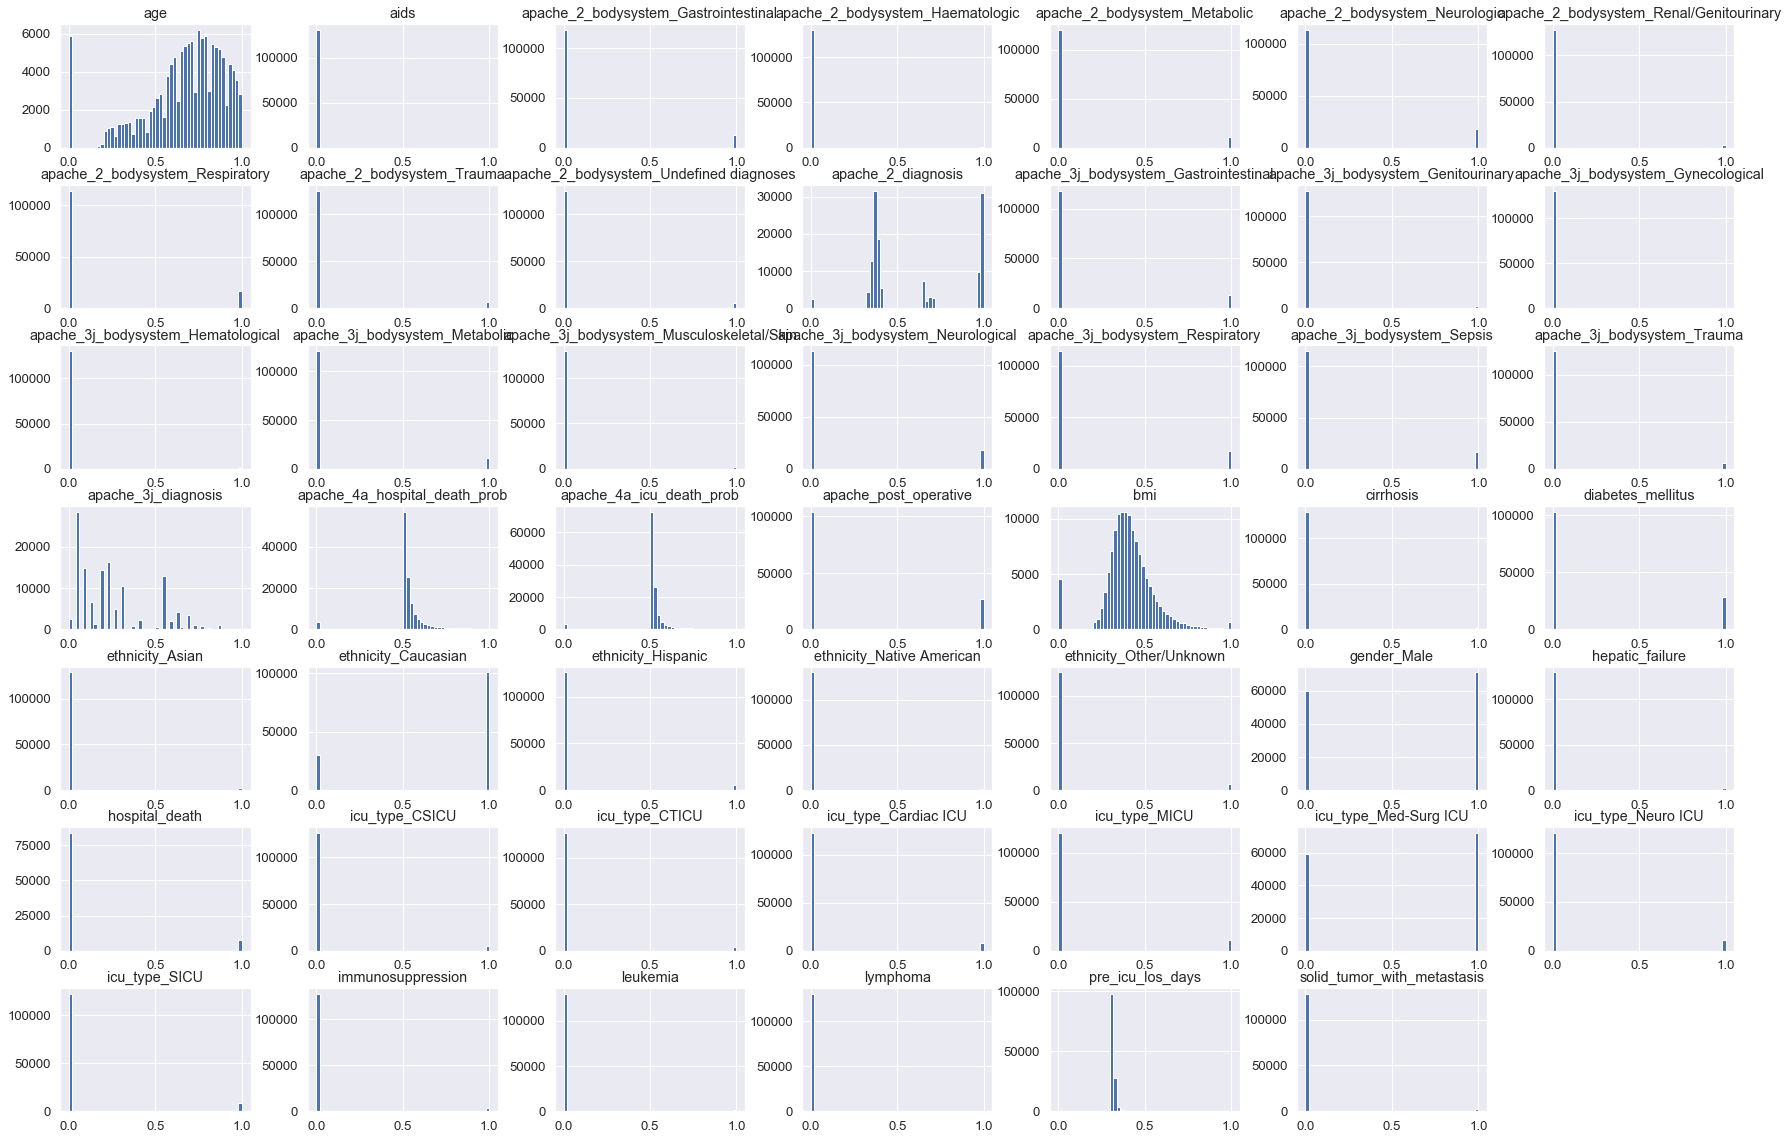

In [50]:
wids.hist(bins = 50, figsize = (30,20))
plt.show()

In [51]:
wids.describe()

,hospital_death,age,bmi,pre_icu_los_days,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,...,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma,apache_2_bodysystem_Gastrointestinal,apache_2_bodysystem_Haematologic,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined diagnoses
count,91713.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,...,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000,131021.000000
mean,0.086302,0.665181,0.413816,0.321600,0.590388,0.253742,0.205746,0.541610,0.527133,0.001023,...,0.125186,0.047603,0.099030,0.006335,0.082056,0.136505,0.025889,0.128934,0.047603,0.044687
std,0.280811,0.234277,0.143161,0.009715,0.288399,0.212588,0.404247,0.119854,0.107583,0.031964,...,0.330931,0.212926,0.298703,0.079340,0.274450,0.343325,0.158805,0.335128,0.212926,0.206618
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.561372,0.339998,0.318539,0.366706,0.092229,0.000000,0.507538,0.512690,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.707582,0.402400,0.318965,0.395935,0.185371,0.000000,0.522613,0.517766,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.831297,0.479366,0.320005,0.977266,0.319404,0.000000,0.562814,0.532995,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
wids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131021 entries, 0 to 39307
Data columns (total 48 columns):
hospital_death                               91713 non-null float64
age                                          131021 non-null float64
bmi                                          131021 non-null float64
pre_icu_los_days                             131021 non-null float64
apache_2_diagnosis                           131021 non-null float64
apache_3j_diagnosis                          131021 non-null float64
apache_post_operative                        131021 non-null int64
apache_4a_hospital_death_prob                131021 non-null float64
apache_4a_icu_death_prob                     131021 non-null float64
aids                                         131021 non-null float64
cirrhosis                                    131021 non-null float64
diabetes_mellitus                            131021 non-null float64
hepatic_failure                              131021 non-null floa

## Training and Testing Splitting

In [53]:
# Split into test and train
wids_train = wids.iloc[:91713]
wids_test = wids.iloc[91713:]

In [54]:
wids_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91713 entries, 0 to 91712
Data columns (total 48 columns):
hospital_death                               91713 non-null float64
age                                          91713 non-null float64
bmi                                          91713 non-null float64
pre_icu_los_days                             91713 non-null float64
apache_2_diagnosis                           91713 non-null float64
apache_3j_diagnosis                          91713 non-null float64
apache_post_operative                        91713 non-null int64
apache_4a_hospital_death_prob                91713 non-null float64
apache_4a_icu_death_prob                     91713 non-null float64
aids                                         91713 non-null float64
cirrhosis                                    91713 non-null float64
diabetes_mellitus                            91713 non-null float64
hepatic_failure                              91713 non-null float64
immunosup

In [55]:
# Split Train into Train and Validate
from  sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(wids_train, wids_train['hospital_death']):
    strat_train_set = wids_train.loc[train_index]
    strat_test_set = wids_train.loc[test_index]

In [56]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18343 entries, 72745 to 14874
Data columns (total 48 columns):
hospital_death                               18343 non-null float64
age                                          18343 non-null float64
bmi                                          18343 non-null float64
pre_icu_los_days                             18343 non-null float64
apache_2_diagnosis                           18343 non-null float64
apache_3j_diagnosis                          18343 non-null float64
apache_post_operative                        18343 non-null int64
apache_4a_hospital_death_prob                18343 non-null float64
apache_4a_icu_death_prob                     18343 non-null float64
aids                                         18343 non-null float64
cirrhosis                                    18343 non-null float64
diabetes_mellitus                            18343 non-null float64
hepatic_failure                              18343 non-null float64
immun

In [57]:
strat_test_set['hospital_death'].value_counts()

0.0    16760
1.0     1583
Name: hospital_death, dtype: int64

In [58]:
strat_train_set['hospital_death'].value_counts()

0.0    67038
1.0     6332
Name: hospital_death, dtype: int64

In [59]:
wids = strat_train_set.copy()

In [60]:
wids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73370 entries, 59226 to 62340
Data columns (total 48 columns):
hospital_death                               73370 non-null float64
age                                          73370 non-null float64
bmi                                          73370 non-null float64
pre_icu_los_days                             73370 non-null float64
apache_2_diagnosis                           73370 non-null float64
apache_3j_diagnosis                          73370 non-null float64
apache_post_operative                        73370 non-null int64
apache_4a_hospital_death_prob                73370 non-null float64
apache_4a_icu_death_prob                     73370 non-null float64
aids                                         73370 non-null float64
cirrhosis                                    73370 non-null float64
diabetes_mellitus                            73370 non-null float64
hepatic_failure                              73370 non-null float64
immun

In [61]:
# Train Data
labels_train = wids.columns[1:]

X_train = wids[labels_train]
y_train = wids['hospital_death']

# Transform into arrays for scikit-learn
X_train = X_train.values
y_train = y_train.values

In [62]:
# Validation Data
wids_valid = strat_test_set.copy()
labels_valid = wids_valid.columns[1:]

X_valid = wids_valid[labels_valid]
y_valid = wids_valid['hospital_death']

# Transform into arrays for scikit-learn
X_valid = X_valid.values
y_valid = y_valid.values

In [63]:
# Test Data
wids_test = wids_test.copy()
labels_test = wids_test.columns[1:]

X_test = wids_test[labels_test]
y_test = wids_test['hospital_death']

# Transform into arrays for scikit-learn
X_test = X_test.values
y_test = y_test.values

## Looking for Correlations

In [64]:
corr_matrix = wids.corr()

In [65]:
corr_matrix['hospital_death'].sort_values(ascending = False)

hospital_death                               1.000000
apache_4a_hospital_death_prob                0.298768
apache_4a_icu_death_prob                     0.273095
apache_3j_bodysystem_Sepsis                  0.099092
pre_icu_los_days                             0.062964
age                                          0.050560
solid_tumor_with_metastasis                  0.049256
immunosuppression                            0.042791
hepatic_failure                              0.040386
cirrhosis                                    0.040015
icu_type_MICU                                0.039788
apache_2_bodysystem_Respiratory              0.037501
apache_3j_bodysystem_Respiratory             0.037501
leukemia                                     0.027372
lymphoma                                     0.019196
icu_type_Cardiac ICU                         0.011230
ethnicity_Caucasian                          0.007746
ethnicity_Hispanic                           0.007042
icu_type_Med-Surg ICU       

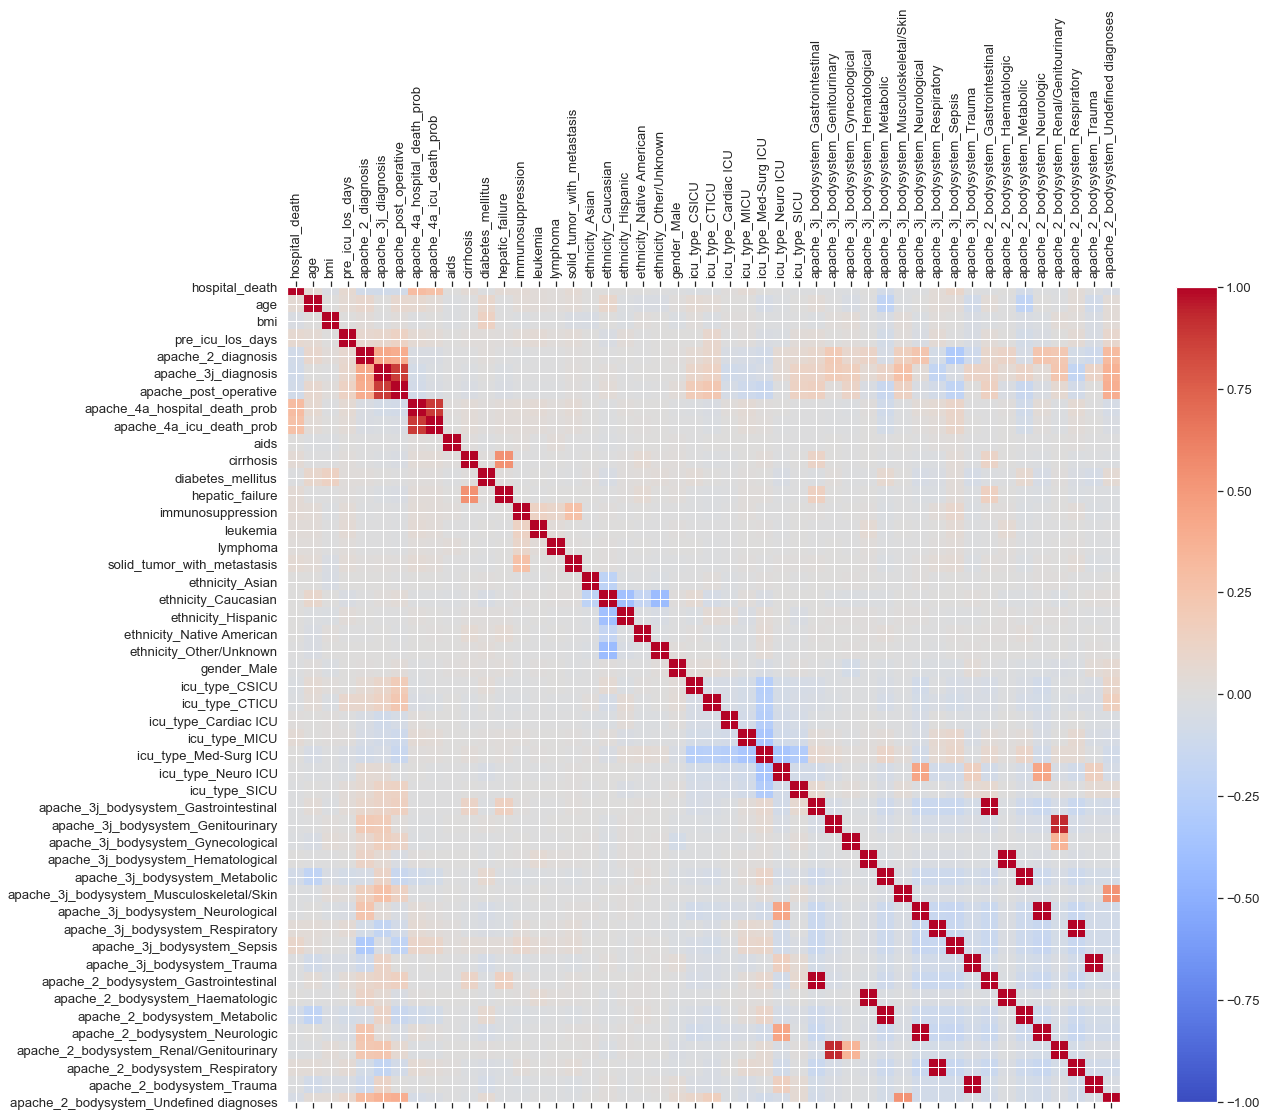

In [66]:
corr = wids.corr()
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(wids.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(wids.columns)
ax.set_yticklabels(wids.columns)
plt.show()

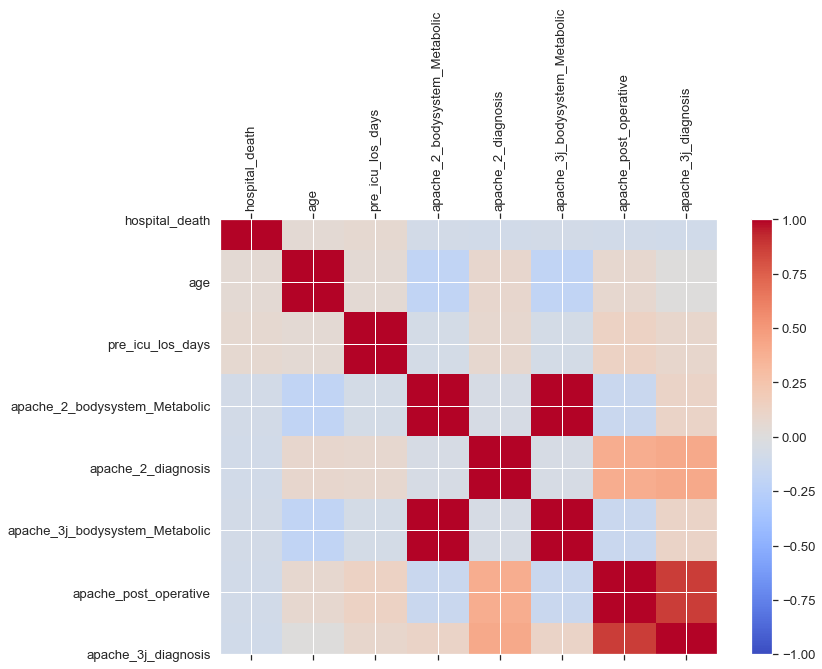

In [67]:
attributes = ["hospital_death", "age", "pre_icu_los_days", "apache_2_bodysystem_Metabolic", "apache_2_diagnosis", "apache_3j_bodysystem_Metabolic", "apache_post_operative", "apache_3j_diagnosis"]
corr = wids[attributes].corr()
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(wids[attributes].columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(wids[attributes].columns)
ax.set_yticklabels(wids[attributes].columns)
plt.show()

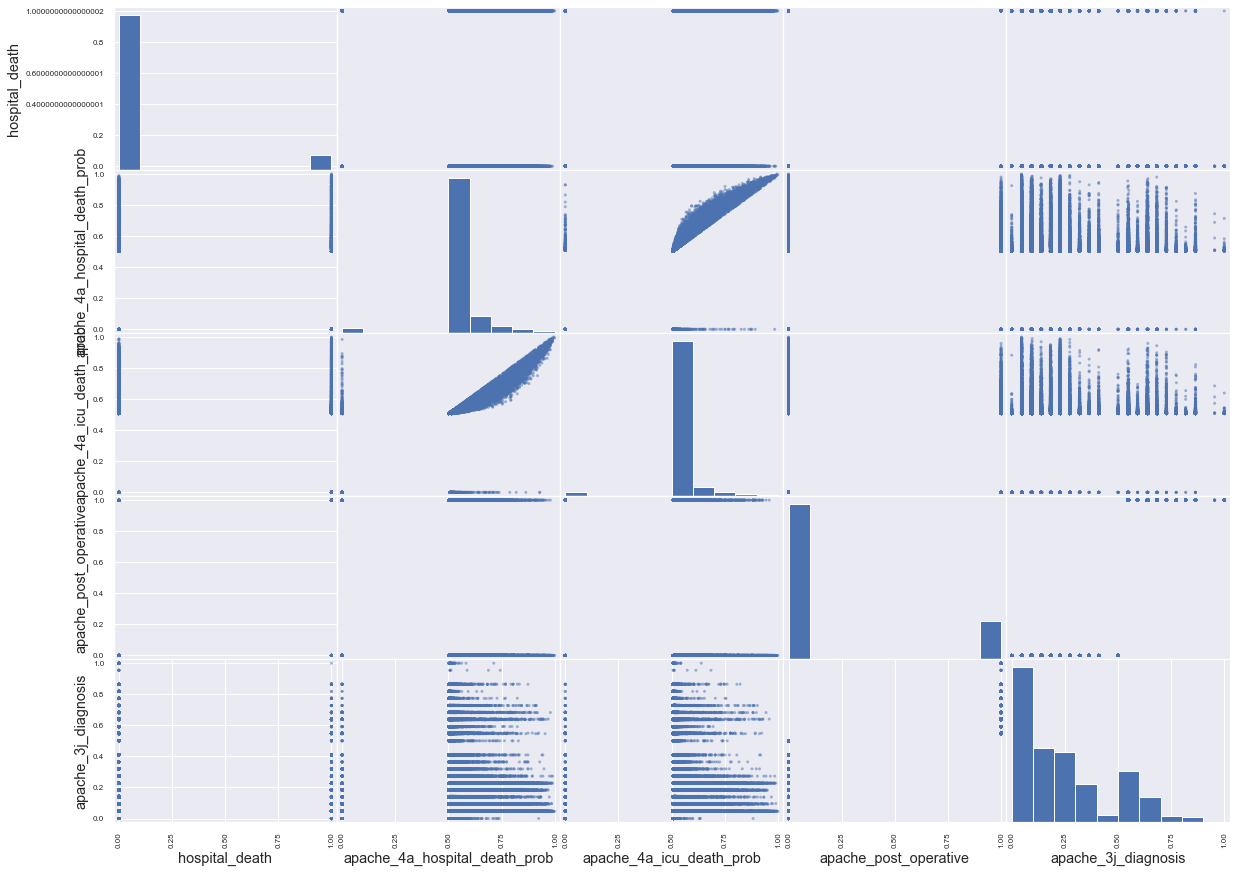

In [68]:
from pandas.plotting import scatter_matrix
attributes = ["hospital_death", 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'apache_post_operative', 'apache_3j_diagnosis']
scatter_matrix(wids[attributes], figsize = (20,15))
plt.show() # strong correlation between RM and MEDV and between LSTAT and MEDV

## Create a Pipeline

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
my_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
])

## Selecting a Desired Model

In [70]:
# Add Logistic Regressor
lr = LogisticRegression()
lr.fit(X_train, y_train)

C:\Users\kamsi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [71]:
# Decision Tree
dtree = tree.DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [72]:
# Random Forest 
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [73]:
# SVM 
svm = SVC()
svm.fit(X_train, y_train)

C:\Users\kamsi\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [74]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [75]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [76]:
# XGBoost Classifier
xgb = XGBClassifier(random_state=1,learning_rate=0.11, gamma = 1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.11, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [77]:
# Tensorflow Keras
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(128, input_shape=(47,), kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(64, kernel_initializer ='glorot_uniform', activation='relu'))
    model.add(Dense(len(np.unique(y_train)), kernel_initializer = 'glorot_uniform', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    return model

In [78]:
# create model
# Tried optimizer rmsprop also, but SGD gave the best result. Also, tried different activation functions, but softmax gave the best result.
nn = KerasClassifier(build_fn=create_model, epochs=30, batch_size=10, verbose=0)

In [79]:
nn.fit(X_train, y_train)

## Predictions

In [80]:
# Logistic Regression
y_pred_lr = lr.predict(X_valid)

In [81]:
# Decision Tree
y_pred_tree = dtree.predict(X_valid)

In [82]:
# Random Forest 
y_pred_rf = rf.predict(X_valid)

In [83]:
# SVM 
y_pred_svm = svm.predict(X_valid)

In [84]:
# Naive Bayes 
y_pred_nb = nb.predict(X_valid)

In [85]:
# Gradient Boosting
y_pred_gbc = gbc.predict(X_valid)

In [86]:
# XG Boost
y_pred_xgb = xgb.predict(X_valid)

In [87]:
# Neural Network
y_pred_nn = nn.predict(X_valid)

### Accuracy Score

In [88]:
from sklearn import metrics

# Logistic Regression
print("Logistic Regression: ", metrics.accuracy_score(y_valid, y_pred_lr))

Logistic Regression:  0.9217140053426375


In [89]:
# Decision Tree
print("Decision Tree: ", metrics.accuracy_score(y_valid, y_pred_tree))

Decision Tree:  0.8742299514801286


In [90]:
# Random Forest
print("Random Forest: ", metrics.accuracy_score(y_valid, y_pred_rf))

Random Forest:  0.9206781878645804


In [91]:
# SVM
print("SVM: ", metrics.accuracy_score(y_valid, y_pred_svm))

SVM:  0.9137000490650384


In [92]:
# Naive Bayes
print("Naive Bayes: ", metrics.accuracy_score(y_valid, y_pred_nb))

Naive Bayes:  0.6939977102982064


In [93]:
# Gradient Boosting
print("Gradient Boosting: ", metrics.accuracy_score(y_valid, y_pred_gbc))

Gradient Boosting:  0.9215504552145233


In [94]:
# XG Boost Classifier
print("XG Boost Classifier: ", metrics.accuracy_score(y_valid, y_pred_xgb))

XG Boost Classifier:  0.9222591724363517


In [95]:
# Neural Network Classifier
print("Neural Network Classifier: ", metrics.accuracy_score(y_valid, y_pred_nn))

Neural Network Classifier:  0.9214959385051519


## Evaluating Model

In [96]:
# Confusion Matrix
print("Logistic Regression: \n", metrics.confusion_matrix(y_valid, y_pred_lr))
print("Decision Tree: \n", metrics.confusion_matrix(y_valid, y_pred_tree))
print("Random Forest: \n", metrics.confusion_matrix(y_valid, y_pred_rf))
print("SVM: \n", metrics.confusion_matrix(y_valid, y_pred_svm))
print("Naive Bayes: \n", metrics.confusion_matrix(y_valid, y_pred_nb))
print("Gradient Boosting: \n", metrics.confusion_matrix(y_valid, y_pred_gbc))
print("XG Boost Classifier: \n", metrics.confusion_matrix(y_valid, y_pred_xgb))
print("Neural Network Classifier: \n", metrics.confusion_matrix(y_valid, y_pred_nn))

Logistic Regression: 
 [[16599   161]
 [ 1275   308]]
Decision Tree: 
 [[15516  1244]
 [ 1063   520]]
Random Forest: 
 [[16551   209]
 [ 1246   337]]
SVM: 
 [[16760     0]
 [ 1583     0]]
Naive Bayes: 
 [[11675  5085]
 [  528  1055]]
Gradient Boosting: 
 [[16535   225]
 [ 1214   369]]
XG Boost Classifier: 
 [[16548   212]
 [ 1214   369]]
Neural Network Classifier: 
 [[16510   250]
 [ 1190   393]]


Surprisingly, True Negative and False Negative are both zero for SVM technique even though the accuracy score is 0.91. This means that this would give zero recall and zero precision score plus we cannot create ROC curve with this technique. Therefore, this technique will not be considered when compared to any other technique

In [97]:
# Recall 
print("Logistic Regression: \n", metrics.recall_score(y_valid, y_pred_lr))
print("Decision Tree: \n", metrics.recall_score(y_valid, y_pred_tree))
print("Random Forest: \n", metrics.recall_score(y_valid, y_pred_rf))
print("SVM: \n", metrics.recall_score(y_valid, y_pred_svm))
print("Naive Bayes: \n", metrics.recall_score(y_valid, y_pred_nb))
print("Gradient Boosting: \n", metrics.recall_score(y_valid, y_pred_gbc))
print("XG Boost Classifier: \n", metrics.recall_score(y_valid, y_pred_xgb))
print("Neural Network Classifier: \n", metrics.recall_score(y_valid, y_pred_nn))

Logistic Regression: 
 0.1945672773215414
Decision Tree: 
 0.32849020846494
Random Forest: 
 0.21288692356285535
SVM: 
 0.0
Naive Bayes: 
 0.6664560960202148
Gradient Boosting: 
 0.23310170562223625
XG Boost Classifier: 
 0.23310170562223625
Neural Network Classifier: 
 0.24826279216677194


In [98]:
#Precision
print("Logistic Regression: \n", metrics.precision_score(y_valid, y_pred_lr))
print("Decision Tree: \n", metrics.precision_score(y_valid, y_pred_tree))
print("Random Forest: \n", metrics.precision_score(y_valid, y_pred_rf))
print("SVM: \n", metrics.precision_score(y_valid, y_pred_svm))
print("Naive Bayes: \n", metrics.precision_score(y_valid, y_pred_nb))
print("Gradient Boosting: \n", metrics.precision_score(y_valid, y_pred_gbc))
print("XG Boost Classifier: \n", metrics.precision_score(y_valid, y_pred_xgb))
print("Neural Network Classifier: \n", metrics.precision_score(y_valid, y_pred_nn))

Logistic Regression: 
 0.6567164179104478
Decision Tree: 
 0.2947845804988662
Random Forest: 
 0.6172161172161172
SVM: 
 0.0
Naive Bayes: 
 0.17182410423452768
Gradient Boosting: 
 0.6212121212121212
XG Boost Classifier: 
 0.6351118760757315
Neural Network Classifier: 
 0.6111975116640747


C:\Users\kamsi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## ROC Curve

In [99]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

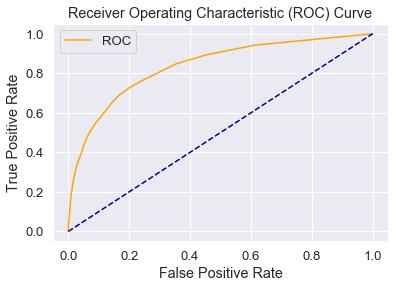

AUC-ROC - Random Forest: 0.8357483374216201


In [100]:
probs_rf = rf.predict_proba(X_valid)
probs_rf = probs_rf[:, 1]
auc = roc_auc_score(y_valid, probs_rf)
fpr, tpr, thresholds = roc_curve(y_valid, probs_rf)
plot_roc_curve(fpr, tpr)
print("AUC-ROC - Random Forest:",auc)

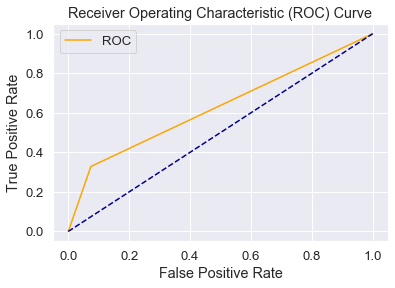

AUC-ROC - Decision Tree: 0.6271329323947612


In [101]:
probs_dtree = dtree.predict_proba(X_valid)
probs_dtree = probs_dtree[:, 1]
auc = roc_auc_score(y_valid, probs_dtree)
fpr, tpr, thresholds = roc_curve(y_valid, probs_dtree)
plot_roc_curve(fpr, tpr)
print("AUC-ROC - Decision Tree:",auc)

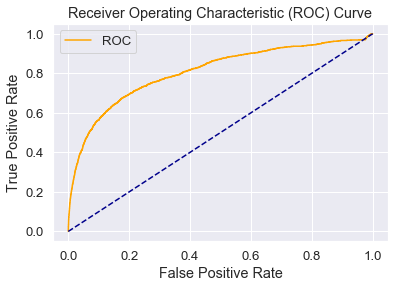

AUC-ROC - Logistic Regression: 0.8076687417172613


In [102]:
probs_lr = lr.predict_proba(X_valid)
probs_lr = probs_lr[:, 1]
auc = roc_auc_score(y_valid, probs_lr)
fpr, tpr, thresholds = roc_curve(y_valid, probs_lr)
plot_roc_curve(fpr, tpr)
print("AUC-ROC - Logistic Regression:",auc)

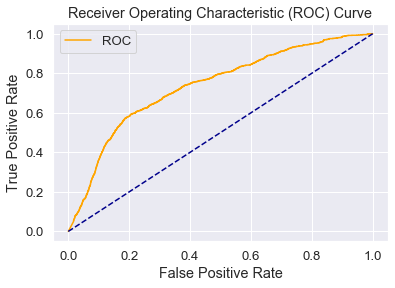

AUC-ROC - Naive Bayes: 0.7354434497201018


In [103]:
probs_nb = nb.predict_proba(X_valid)
probs_nb = probs_nb[:, 1]
auc = roc_auc_score(y_valid, probs_nb)
fpr, tpr, thresholds = roc_curve(y_valid, probs_nb)
plot_roc_curve(fpr, tpr)
print("AUC-ROC - Naive Bayes:",auc)

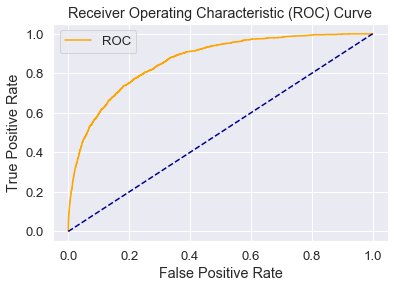

AUC-ROC - Gradient Boosting: 0.8635256838394818


In [104]:
probs_gbc = gbc.predict_proba(X_valid)
probs_gbc = probs_gbc[:, 1]
auc = roc_auc_score(y_valid, probs_gbc)
fpr, tpr, thresholds = roc_curve(y_valid, probs_gbc)
plot_roc_curve(fpr, tpr)
print("AUC-ROC - Gradient Boosting:",auc)

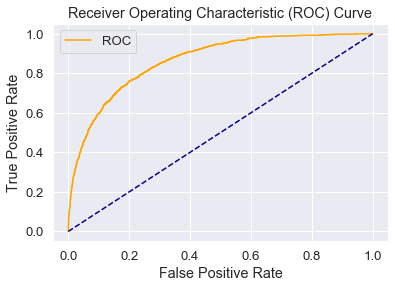

AUC-ROC - XG Boost Classifier: 0.8650376841048311


In [105]:
probs_xgb = xgb.predict_proba(X_valid)
probs_xgb = probs_xgb[:, 1]
auc = roc_auc_score(y_valid, probs_xgb)
fpr, tpr, thresholds = roc_curve(y_valid, probs_xgb)
plot_roc_curve(fpr, tpr)
print("AUC-ROC - XG Boost Classifier:",auc)

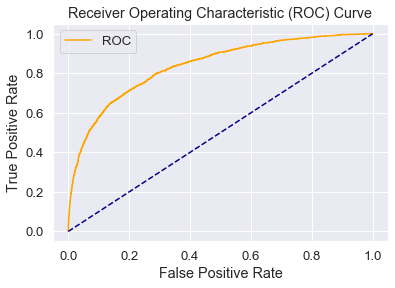

AUC-ROC - Neural Network Classifier: 0.8374642494764629


In [106]:
probs_nn = nn.predict_proba(X_valid)
probs_nn = probs_nn[:, 1]
auc = roc_auc_score(y_valid, probs_nn)
fpr, tpr, thresholds = roc_curve(y_valid, probs_nn)
plot_roc_curve(fpr, tpr)
print("AUC-ROC - Neural Network Classifier:",auc)

## Predicting Probabilities and Saving Model 

In [107]:
test = wids_test.copy()

In [108]:
test = test.drop('hospital_death',axis = 1)

In [109]:
y_pred = xgb.predict_proba(X_test)

In [110]:
df_pred = pd.DataFrame(data = y_pred)

In [111]:
df_pred

,0,1
0,0.926407,0.073593
1,0.971410,0.028590
2,0.985477,0.014523
3,0.820051,0.179949
4,0.185008,0.814992
...,...,...
39303,0.996835,0.003165
39304,0.960479,0.039521
39305,0.916589,0.083410
39306,0.978600,0.021400


In [112]:
df_pred['encounter_id'] = unlabeled['encounter_id']

In [113]:
df_pred

,0,1,encounter_id
0,0.926407,0.073593,2
1,0.971410,0.028590,5
2,0.985477,0.014523,7
3,0.820051,0.179949,8
4,0.185008,0.814992,10
...,...,...,...
39303,0.996835,0.003165,131035
39304,0.960479,0.039521,131037
39305,0.916589,0.083410,131039
39306,0.978600,0.021400,131041


In [114]:
df_pred["hospital_death"] = df_pred[1]

In [115]:
df_pred[["encounter_id", "hospital_death"]].to_csv("submissionf1.csv",index=False)
df_pred[["encounter_id", "hospital_death"]].head()

,encounter_id,hospital_death
0,2,0.073593
1,5,0.028590
2,7,0.014523
3,8,0.179949
4,10,0.814992


In [116]:
df_pred[["encounter_id", "hospital_death"]].tail()

,encounter_id,hospital_death
39303,131035,0.003165
39304,131037,0.039521
39305,131039,0.083410
39306,131041,0.021400
39307,131050,0.054530


# Predciting if Patient Survives or not

In [121]:
y_pred_cat = xgb.predict(X_test)

In [122]:
test1 = unlabeled.copy()

In [123]:
test1["hospital_death"] = y_pred_cat

In [124]:
test1[["encounter_id", "hospital_death"]].to_csv("submission_surv.csv", index = False)
test1[["encounter_id", "hospital_death"]].head()

,encounter_id,hospital_death
0,2,0.0
1,5,0.0
2,7,0.0
3,8,0.0
4,10,1.0
